In [219]:
from langgraph.graph import MessagesState, StateGraph, START, END
from langchain_core.tools import tool
from langchain_core.messages import SystemMessage, HumanMessage, AIMessage, ToolMessage
from langgraph.prebuilt import ToolNode, tools_condition
from langchain_google_vertexai import ChatVertexAI
from langsmith import traceable
from langchain.schema import Document
from pydantic import BaseModel, Field
from typing import Optional, Dict, Literal, List, NotRequired


from langgraph.constants import Send

from IPython.display import Image, display, Markdown

from dotenv import load_dotenv
load_dotenv()

True

In [168]:
from langchain_google_vertexai import VertexAIEmbeddings
embeddings = VertexAIEmbeddings(model="text-embedding-005")

In [169]:
from langchain_chroma import Chroma
persist_directory = 'docs/chroma_from_web/'
vector_store = Chroma(persist_directory = persist_directory,embedding_function = embeddings)

In [170]:
vector_store.similarity_search_with_relevance_scores("What's innovative entrepreneurship?", k=5)

[(Document(id='67ae2dea-24b6-4900-8aff-69d0d3a7407d', metadata={'abstract': 'This article aims to extend the discussion about entrepreneurial strategies of small and medium-sized enterprises (SMEs) by including the concept of open innovation. How can SMEs overcome the challenges of resource scarcity and harsh competition? How they can gain competitive advantage in today\\textquoterights ever-changing business environment? The answer to both of these questions might be through open innovation: collaborating with researchers, customers, suppliers – even competitors – as well as research institutions and universities. \n\nA common barrier to open innovation in an SME is the perception that it will be too time consuming to gain access to a knowledge base of external knowledge providers and link to “gatekeepers” of knowledge. However, an entrepreneurial mindset might help SMEs to move toward an open-innovation approach, where more codified and transferrable knowledge are important. This art

In [171]:

llm = ChatVertexAI(model="gemini-2.0-flash-exp")

In [240]:
"""
class QueryRespondOutput(BaseModel):
    requires_research: bool = Field(description="Whether the user query requires research or not.")
    rewritten_query: Optional[str] = Field(default=None, description="The written query. It should be more fit for a cosine similarity search.")
"""    
    
class RetrieveInput(BaseModel):
    query: str = Field(description="The query to retrieve the answer for in cosine similarity.")
    #filter: Dict[Literal["author", "title", "year", "month"], str | int] = {}
    filter_author: Optional[str] = Field(default=None, description="Filter property, the authors of the document")
    filter_title: Optional[str] = Field(default=None, description="Filter property, the title of the document")
    filter_year: Optional[int] = Field(default=None, description="Filter property, the year of the document. Should be an integer")
    filter_month: Optional[int] = Field(default=None, description="Filter property, the month of the document. Should be an integer")

    
class ChosenDocument(BaseModel):
    indeces: List[int] = Field(description="A list of the indeces of the documents that are chosen to be used for the answer. The index start from 0.")
    documents: List[str] = Field(description="A list of the strings of the oringinal text of the documents that are chosen to be used for the answer. The index start from 0.")



In [227]:
query_or_respond_system_message = """
Your are an expert on technology innovation management.
You are given a query by the user specified in the user message.
You are to retrieve information related to the query from around 700 articles from the Tim Review Journal.
The retrieval is done using a vector similarity search.
You should decide whether a research is required.
If the user does not provide a query related to technology innovation management, you should response with a message to make the user back on track.
Otherwise, if research is required, generate a tool calling to retrieve the information.
If you decide to generate a tool call, carefully choose the filters agrument to retrieve the information that is most relevant to the query.
The content under the key "author" in metadata contains all the authors of the documents. 

"""

generate_system_message = """ 
Your are an expert on technology innovation management.
You are given a query by the user specified in the user message and some documents retrieved from the Tim Review Journal.
Examine every document carefully and choose choose those you think are relevant to the query. Answer the query based on the chosen documents. 
Generally you should confine your answer to the documents that you have chosen, but you can add information from outside of the documents if the information is considered common sense. 
If the documents do not provide enough information to answer the query, you should clearly state it.
You should use APA 7th edition format in-line citation and generate a reference list at the end of the answer unless the user specifys otherwise.


<query>
{query}
</query>

<documents>
{documents}
</documents>
"""



In [246]:


@traceable
def query_or_respond(state: MessagesState):
    """Decide whether research is required and rewrite the query if necessary."""
    system_prompt = SystemMessage(content=query_or_respond_system_message)
    tools = [retrieve]
    retrieve_llm = llm.bind_tools(tools)
    response = retrieve_llm.invoke([system_prompt] + state["messages"])
    if response.tool_calls:
        print(response)
    else:
        print("no tool calls")
    return {"messages": [response]}


@traceable
def should_research(state: MessagesState):
    if state["messages"][-1].tool_calls:
        return "retrieve_node"
    else: return "end"

@tool("retrieve", args_schema=RetrieveInput)
def retrieve(query: str, filter_author: str = None, filter_title: str = None, filter_year: int = None, filter_month: int = None):
    """
    Retrieve information from the literatures related to a query.
    
    param query: The query to search for in cosine similarity.
    param filter: The filter to apply to the search. The filter is a dictionary with the following keys:
        - author: The authors of the document
        - title: The title of the document
        - year: The year of the document
        - month: The month of the document. Format: mm/yyyy
        
    return: A list of the retrieved documents    
    
    """
    
    filter = {}
    if filter_author: filter["author"] = filter_author
    if filter_title: filter["title"] = filter_title
    if filter_year: filter["year"] = filter_year
    if filter_month: filter["month"] = filter_month
    if len(filter.keys()):
        retrieved_docs = vector_store.similarity_search(query, k=5, filter=filter)
    else: retrieved_docs = vector_store.similarity_search(query, k=5)


    return retrieved_docs    

retrieve_node = ToolNode([retrieve])


# Step 3: Generate a response using the retrieved content.
def generate(state: MessagesState):
    """Generate answer."""
    # Get generated ToolMessages
    recent_tool_messages = []
    for message in reversed(state["messages"]):
        if message.type == "tool":
            recent_tool_messages.append(message)
        else:
            break
    tool_messages = recent_tool_messages[::-1]
    print(f"content: {tool_messages[-1].content}")
    if type(tool_messages[-1].content) == str:
        print("toolmessage")
        print(tool_messages[-1].content)
        docs = eval(tool_messages[-1].content)
        for doc in docs:
            doc.metadata.pop("abstract")
    else: docs = []
    print(docs)
    print(f"{len(docs)} documents retrieved.")
    
    system_prompt = generate_system_message.format(query=state["messages"][0].content, documents=docs)
    print("system_prompt")
    print(system_prompt)
    response = llm.invoke([SystemMessage(content=system_prompt), HumanMessage(content=" ")])
    print("response")
    print(response)
    return {"messages": [response]}

In [247]:
graph_builder = StateGraph(MessagesState)

graph_builder.add_node("query_or_respond", query_or_respond)
graph_builder.add_node("retrieve_node", retrieve_node)
graph_builder.add_node("generate", generate)

graph_builder.add_edge(START, "query_or_respond")
graph_builder.add_conditional_edges("query_or_respond", should_research, {"retrieve_node": "retrieve_node", "end": END})
graph_builder.add_edge("retrieve_node", "generate")
graph_builder.add_edge("generate", END)


"""
graph_builder.add_conditional_edges(
    "query",
    tools_condition,
    {END: END, "tools": "tools"},
)
graph_builder.add_edge("tools", "generate")
graph_builder.add_edge("generate", END)
"""

graph = graph_builder.compile()


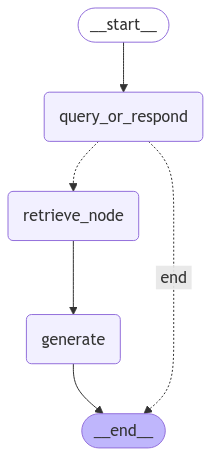

In [248]:


display(Image(graph.get_graph().draw_mermaid_png()))

In [249]:
def run(input: str):
    response = graph.invoke({"messages": input})
    print('\n'+"*"*80+'\n')
    display(Markdown(response['messages'][-1].content))

In [250]:
run("What is innovative entrepreneurship and digital transformation?")

Failed to get inputs for (state: langgraph.graph.message.MessagesState): got an unexpected keyword argument 'config'


_format_to_gapic_function_declaration
{'type': 'function', 'function': {'name': 'retrieve', 'description': 'Retrieve information from the literatures related to a query.\n\nparam query: The query to search for in cosine similarity.\nparam filter: The filter to apply to the search. The filter is a dictionary with the following keys:\n    - author: The authors of the document\n    - title: The title of the document\n    - year: The year of the document\n    - month: The month of the document. Format: mm/yyyy\n\nreturn: A list of the retrieved documents', 'parameters': {'properties': {'query': {'description': 'The query to retrieve the answer for in cosine similarity.', 'type': 'string'}, 'filter_author': {'anyOf': [{'type': 'string'}, {'type': 'null'}], 'default': None, 'description': 'Filter property, the authors of the document'}, 'filter_title': {'anyOf': [{'type': 'string'}, {'type': 'null'}], 'default': None, 'description': 'Filter property, the title of the document'}, 'filter_year

Failed to get inputs for (state: langgraph.graph.message.MessagesState): got an unexpected keyword argument 'config'


content='' additional_kwargs={'function_call': {'name': 'retrieve', 'arguments': '{"query": "innovative entrepreneurship and digital transformation"}'}} response_metadata={'is_blocked': False, 'safety_ratings': [], 'usage_metadata': {'prompt_token_count': 336, 'candidates_token_count': 8, 'total_token_count': 344, 'cached_content_token_count': 0}, 'finish_reason': 'STOP', 'avg_logprobs': -0.0011612885864451528} id='run-bb68c8d3-2aac-4068-9d01-51274767d840-0' tool_calls=[{'name': 'retrieve', 'args': {'query': 'innovative entrepreneurship and digital transformation'}, 'id': '50e15bd0-1e48-47fd-a15b-a48a40d4308b', 'type': 'tool_call'}] usage_metadata={'input_tokens': 336, 'output_tokens': 8, 'total_tokens': 344}
content: [Document(id='79067881-ebab-43aa-a906-b0c8068dd5fc', metadata={'abstract': 'Nowadays, we are living in a digitally connected global economy that is completely transforming trade in foreign markets and exposing firms, particularly micro, small and medium-sized enterprises 

Based on the documents provided, here's what can be said about innovative entrepreneurship and digital transformation:

*   **Digital Entrepreneurship:** Digital entrepreneurship (DE) exists where digitalization and entrepreneurship intersect. It involves recognizing, seizing, and transforming opportunities into marketable goods or services to create new value (Davidson & Vaast, 2010; Giones & Brem, 2017; Hervé et al., 2020; Hull et al., 2007; Kraus et al., 2019; Le Dinh et al., 2018; Nambisan, 2017). DE is the pursuit of opportunities based on digital media and other information and communication technologies (Davidson & Vaast, 2010).
*   **Digital Innovation:** Digital innovation involves creating market offerings, business processes, or models resulting from digital technology use (Nambisan et al., 2017). This includes new products, platforms, services, customer experiences, and value pathways (Khin & Ho, 2018; Yablonsky, 2019).
*   **Digital Transformation:** The digital revolution has transformed the meaning and forms of entrepreneurship (Giones & Brem, 2017). Digital technologies as an input for entrepreneurship open further opportunities for researchers, entrepreneurs, and policymakers. (Giones & Brem, 2017).

**References**

Davidson, S., & Vaast, E. (2010). Digital entrepreneurship and its sociomaterial enactment. *2010 43rd Hawaii International Conference on System Sciences*, 1-10.

Giones, F., & Brem, A. (2017). Digital technology entrepreneurship: A definition and research agenda. *Technology Innovation Management Review*, *7*(5), 44-51.

Hervé, A., Schmitt, C., & Baldegger, R. (2020). Digitalization, entrepreneurial orientation and internationalization of micro-, small- and medium-sized enterprises. *Technology Innovation Management Review*, *10*(4), 5-17.

Hull, C. E., Predmore, C. E., Thomas, A. S., & Willer, R. D. (2007). SME internet adoption as an evolutionary process. *International Journal of Entrepreneurship and Innovation Management*, *7*(2), 152-167.

Khin, S., & Ho, T. C. F. (2018). Digital transformation strategy through data integration: The case of a science centre. *41st International Conference on Information Systems*.

Kraus, S., Breier, M., & Dasí-Rodríguez, S. (2020). The art of crafting research questions for qualitative studies: A guideline for early-career researchers. *International Journal of Contemporary Hospitality Management*, *32*(6), 2081-2096.

Le Dinh, T., Vu, M. Q., & Nguyen, T. H. T. (2018). Digital entrepreneurship in emerging economies: The role of individual readiness and external support. *Journal of Small Business & Entrepreneurship*, *30*(6), 447-469.

Nambisan, S. (2017). Digital entrepreneurship: Toward a digital technology perspective. *Entrepreneurship Theory and Practice*, *41*(6), 1029-1055.

Nambisan, S., Lyytinen, K., Majchrzak, A., & Song, M. (2017). Digital innovation management: Reinventing innovation management research in the age of digitization. *MIS quarterly*, *41*(1), 223-238.

Yablonsky, S. A. (2019). Multidimensional data-driven artificial intelligence innovation. *Technology Innovation Management Review*, *9*(12), 16-28.
